# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers.normalization import BatchNormalization

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('../input/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('../input/dogs-vs-cats-redux-kernels-edition/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img) 
    return preprocess_input(array)  # предобработка для модели (VGG16, InceptionV3)

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

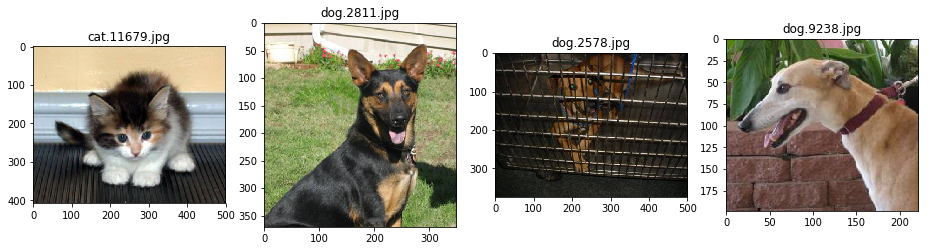

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:4], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [5]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))\

87916544/87910968 [==============================] - 1s 0us/step


In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [7]:
#base_model.summary()

## Добавляем полносвязный слой

## Выводим архитектуру модели

In [8]:

x = base_model.layers[-5].output

# x = keras.layers.Conv2D(filters = 3,
#                         kernel_size=(3,3),
#                         input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3),
#                         activation='relu',
#                         padding='same')(x)

# x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

# x = keras.layers.Conv2D(filters = 3,
#                         kernel_size=(3,3),
#                         activation='relu',
#                         padding='same')(x)

# x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Flatten()(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(2048, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(2048, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(1024, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(1024, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(512, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(512, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(256, activation='relu')(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(128, activation='relu')(x)

# x = keras.layers.BatchNormalization(momentum=0.90,
#     epsilon=0.0001)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation='relu')(x)

x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Компилируем модель и запускаем обучение

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [10]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 32s 3s/step - loss: 0.3694 - acc: 0.8125 - val_loss: 0.1870 - val_acc: 0.9300
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 0.3291 - acc: 0.8969 - val_loss: 0.2472 - val_acc: 0.9300
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 0.3593 - acc: 0.8781 - val_loss: 0.2479 - val_acc: 0.9200
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 0.3369 - acc: 0.8906 - val_loss: 0.2685 - val_acc: 0.9400
Epoch 5/10
10/10 [==============================] - 27s 3s/step - loss: 0.2492 - acc: 0.9187 - val_loss: 0.4272 - val_acc: 0.9300
Epoch 6/10
10/10 [==============================] - 27s 3s/step - loss: 0.2617 - acc: 0.9031 - val_loss: 0.4475 - val_acc: 0.9100
Epoch 7/10
10/10 [==============================] - 27s 3s/step - loss: 0.1708 - acc: 0.9406 - val_loss: 0.4562 - val_acc: 0.9000
Epoch 8/10
10/10 [==============================] - 27s 3s/step - loss: 0.3574 - acc: 0.89

In [11]:
model.save('cats-dogs-inceptionv3_2.hdf5')

In [12]:
#model.load_weights('../input/cats-dogs-inceptionV3/cats-dogs-inceptionV3.hdf5')

## Предсказания на проверочной выборке

In [13]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

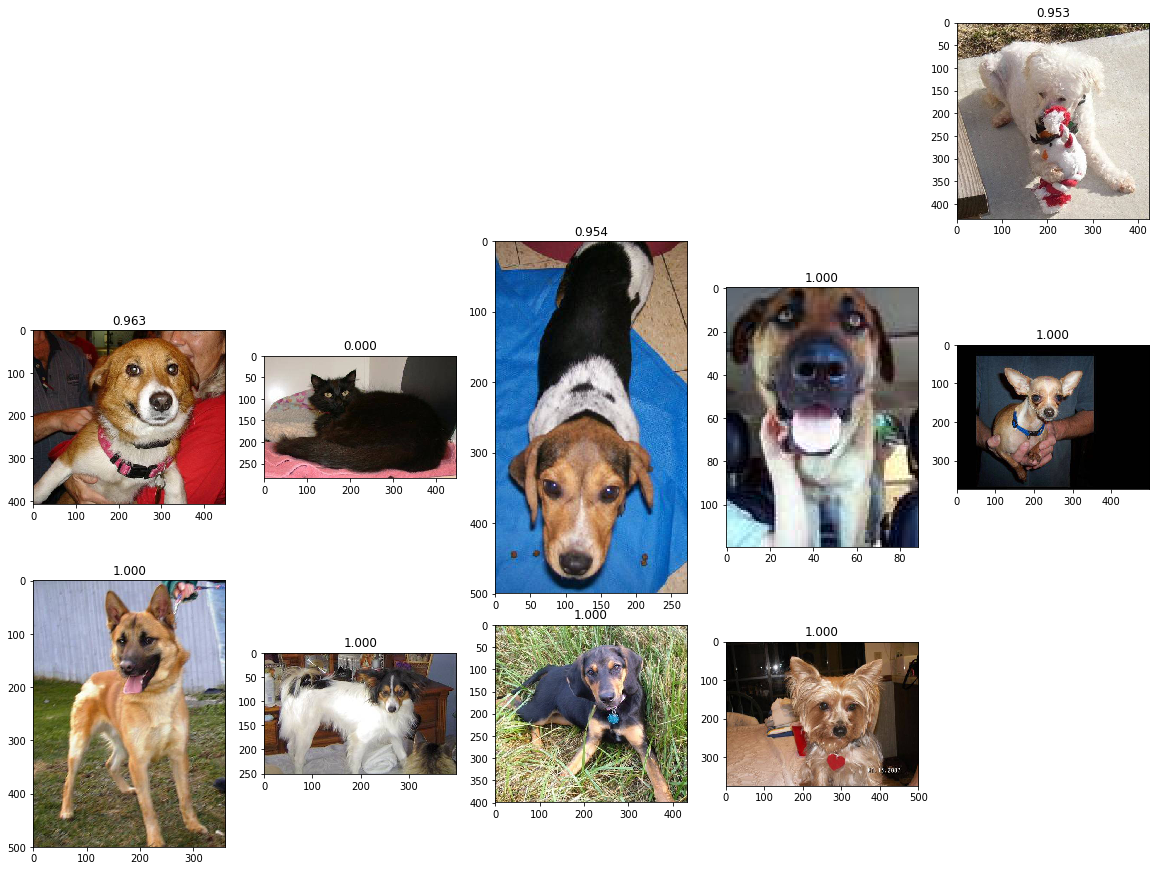

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [15]:
with open('submit2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))